In [1]:
import sys
import pickle
from scipy import signal
from scipy import stats
import numpy as np
import math
from collections import OrderedDict


import matplotlib.pyplot as plt

sys.path.append('D:\Diamond\code')
from csp_james_2 import *

sys.path.append('D:\Diamond\code')
from thesis_funcs_19_03 import *

import csv
from random import randint
import random
import datetime
import scipy
import pandas as pd

In [21]:
def locate_mi_cues_from_csv (csv):
    
    """
    find the start of MI cue in the csv file of eeg recording, created by Openvibe streaming g.tecUSBamp
    take in a csv file opened by pandas. look into the 'Event Id' column, find the code corresponding to MI. \
    codes are found from http://openvibe.inria.fr/stimulation-codes/
    
    INPUT:
        csv opened by pd.readcsv(csv_path)
    OUTPUT:
        HEADS:
            the start of MI cue, index of csv row (representing timestamp). It is the cue onset, meaning actual MI is about 0.5s after.
            e.g. [12826 18606 24343 30128 35965 41849 47740 53424 59209 64995 70884 76515 82199 87882]
        LABELS:
            the label(class) of the MI cue. np.array, e.g. [2 2 2 1 2 1 1 1 1 2 2 1 1 2]
    """

    HEADS =[] #the timepoint index that mark the cue
    LABELS = [] #the class of MI, 1 is left hand, 2 is right hand

    for row in range (0, csv.last_valid_index()):
        try:
            Event_id = str( csv['Event Id'][row])
            if Event_id != 'nan':
                if ('1090' in Event_id) != ('1089' in Event_id):
                    if ('1090' in Event_id):
                        #print (row, Event_id, 'right hand')
                        HEADS.append(row)
                        LABELS.append(2)
                    if ('1089' in Event_id):
                        #print (row, Event_id, 'left hand')
                        HEADS.append(row)
                        LABELS.append(1)
                else:
                    print (row, 'yo', Event_id)
        except:
                print ('ummm', row, csv['Event Id'][row])

    HEADS = np.array(HEADS)
    LABELS = np.array(LABELS)
    
    return HEADS, LABELS

In [40]:
sub_id = 's2'
record_names = np.arange(1,11) #usually the number of recordings

mi_period = 4 + 0.5 #4 seconds of mi (from cue onset) + 0.5 seconds extra tail for filter effect
fs = 512 #sampling frequency is 512 Hz for the g.tec system


#FILE repository in which the recordings(signals) are stored
raw_eeg_root = 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\signals\\'



for r in record_names:
    print (r)
    #the path to the recording
    raw_record = raw_eeg_root + 'record' + str(r) + '.csv'
    
    #open csv
    csv = pd.read_csv(raw_record)
    #csv.keys()
    
    #extract EEG voltages from 16 channels (from colum 2 to -3 in the csv file)
    EEG_raw = np.transpose(csv.get_values()[:,2:-3].astype('float64')) #each row is a channel, each column is a timepoint. take only field 2:-3 so remove timestamp and epoch, and event infos, so we get only the eeg voltages

    #locate the onset of cues in the csv file (HEADS) and the class label (LABELS)
    HEADS, Labels = locate_mi_cues_from_csv (csv)
    #print (len(Labels))
    
    #extract MI eeg signals,  np.shape(EEG_MI_raw) = [num_runs, num_channels, num_timepoints], e.g. [14, 16, 2304]
    EEG_MI_raw = []
    for h in HEADS:
        EEG_MI_raw.append(EEG_raw[:, h : int(h+mi_period*fs)])
    EEG_MI_raw = np.array(EEG_MI_raw)

    #concatenate the EEG_MI_raw and Labels for this subject, from all her trials
    if r == record_names[0]:
        EEG_MI_RAW = EEG_MI_raw
        LABELS = Labels
    else:
        EEG_MI_RAW = np.concatenate((EEG_MI_RAW, EEG_MI_raw), axis = 0)
        LABELS = np.concatenate((LABELS, Labels), axis = 0)


#save the concatenated raw eeg mi signals and labels for a subject's trials        
pickle.dump( EEG_MI_RAW, open( raw_eeg_root + sub_id + ".pickle", "wb" ) )
pickle.dump( LABELS, open( raw_eeg_root + sub_id + "_LABELS.pickle", "wb" ) )

1
14
2
14
3
15
4
14
5
15
6
14
7
14
8
14
9
14
10
14


In [96]:
#NOT USED BECAUSE A SHORTER SOLUTION FOUND

""" 

for row in range (0, csv.last_valid_index()):
    try:
        event_id = float(csv['Event Id'][row])
        if math.isnan(event_id) == False:
            if int(event_id) == 1090:
                print (row, ' right hand')
            elif int(event_id) == 1089:
                print (row, ' left hand')
        
    except:
        if isinstance(csv['Event Id'][row], str):
            try: 
                event_ids = csv['Event Id'][row].split(':')
                for i in range (0, len(event_ids)):
                    event_ids[i] = event_ids[i].strip()
                if ('1090' in event_ids) != ('1089' in event_ids):
                    if '1090' in event_ids:
                        print (row, ' right hand')
                    
                    elif '1089' in event_ids:
                        print (row, ' left hand')
                else:
                    print (row, ' umm, ', event_ids)
                
            except:
                print (row, ' : not in Event_Id')
                print (csv['Event Id'][row])
    
        

"""     

21606  right hand
27430  right hand
33067  right hand
38912  left hand
44536  right hand
50167  left hand
55798  left hand
61543  left hand
67322  left hand
73209  right hand
79095  right hand
84731  left hand
90413  left hand
96199  right hand


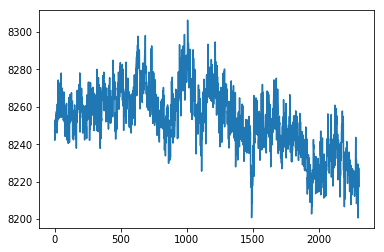

In [46]:
plt.plot(EEG_MI_RAW[0][0])